In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_evolution import folder_gauss, folder_gs
from analytical_results import fT00, fT01, fT11, fj0, fj1, fnu, fLn
from ploting import plot_heatmaps
import matplotlib.cm as cmap

from scripts_fermions.operators import measure_local_observables

import yastn

save = False

In [2]:
g = 1
tol, method = 1e-6, '12site'
#
data = {}
gs = {}
x0 = 1.5
sg2 = 0.25
dt = 1/16
Ps = [0, 1, 2, 4, 6, 8]

for m in [0, 0.5]:
    for (N, a) in [(512, 0.0625)]:
        for P in Ps:
            D0 = 128
            for D in [256, 512]:
                folder = folder_gauss(g, m, a, N, P, x0, sg2, D0, dt, D, tol, method, mkdir=True)
                data[m, P, N, a, D, dt] = np.load(folder / f"results.npy", allow_pickle=True).item()

        fname = folder_gs(g, m, a, N) / f"state_D={D0}.npy"
        gs[m, a, N] = np.load(fname, allow_pickle=True).item()


In [3]:
def plot_heatmaps(ev, data, g, ms, Ps, NaDdt, avarage_nn=False, tmax=None):
    nx, ny = len(ms), len(Ps)

    fig, ax = plt.subplots(nx, ny, figsize=(ny * 5, nx * 5), squeeze=False)  # sharex=True, sharey=True,

    N, a, D, dt = NaDdt
    zmin, zmax = 0, 0
    for m in ms:
        for P in Ps:
            ee = data[m, P, N, a, D, dt][ev][data[m, P, N, a, D, dt]["time"] > -1]
            ee = ee - ee[0, :]
            zmax = max(zmax, np.max(ee))
            zmin = min(zmin, np.min(ee))

    zlim = max(abs(zmin), abs(zmax))

    for i, P in enumerate(Ps):
        for j, m in enumerate(ms):
            tm = data[m, P, N, a, D, dt]["time"]
            mask = tm > -1
            tm = tm[mask]
            ee = data[m, P, N, a, D, dt][ev][mask]

            ee = ee - gs[m, a, N][ev.replace('_1', '')]
            if avarage_nn:
                ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # avarage over 2*n and 2*n+1

            xmax = N * a / 2
            im = ax[j, i].imshow(ee, extent=(-xmax, xmax, 0, tm[-1]),
                                origin='lower', aspect='auto',
                                vmin=-zlim, vmax=zlim,
                                cmap = cmap.seismic)
            ax[j, i].set_title(f"{a=:0.2f} {m/g=:0.2f} {P=:0.2f} {N=} {D=}")
            ax[j, i].set_xticks([-xmax , -xmax / 2, 0, xmax / 2, xmax])
            ax[j, i].set_ylim([0, xmax])
            if tmax:
                ax[j, i].set_ylim([0, tmax ])
                ax[j, i].set_xlim([-tmax, tmax])

    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.10, 0.02, 0.8])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.ax.set_ylim([zmin, zmax])

    fig.text(0.43, -0.01, 'position  (n - n0) * a', ha='center')
    fig.text(-0.01, 0.5, 'time', va='center', rotation='vertical')
    fig.text(0.43, 1.00, ev, ha='center', fontsize=24)
    fig.show()


In [4]:
def get_tsm(signals, gs, ev):
    tm = signals["time"]
    mask = tm > -1
    tm = tm[mask]
    ee = signals[ev][mask]
    ee = ee - gs[ev]
    ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # average over 2*n and 2*n+1
    mid = (ee[:, N // 4] + ee[:, N // 4 - 1])/2
    return tm, ee, mid

In [5]:
NaDdt = (512, 1/16, 512, 1/16)
ms = [0, 0.5]

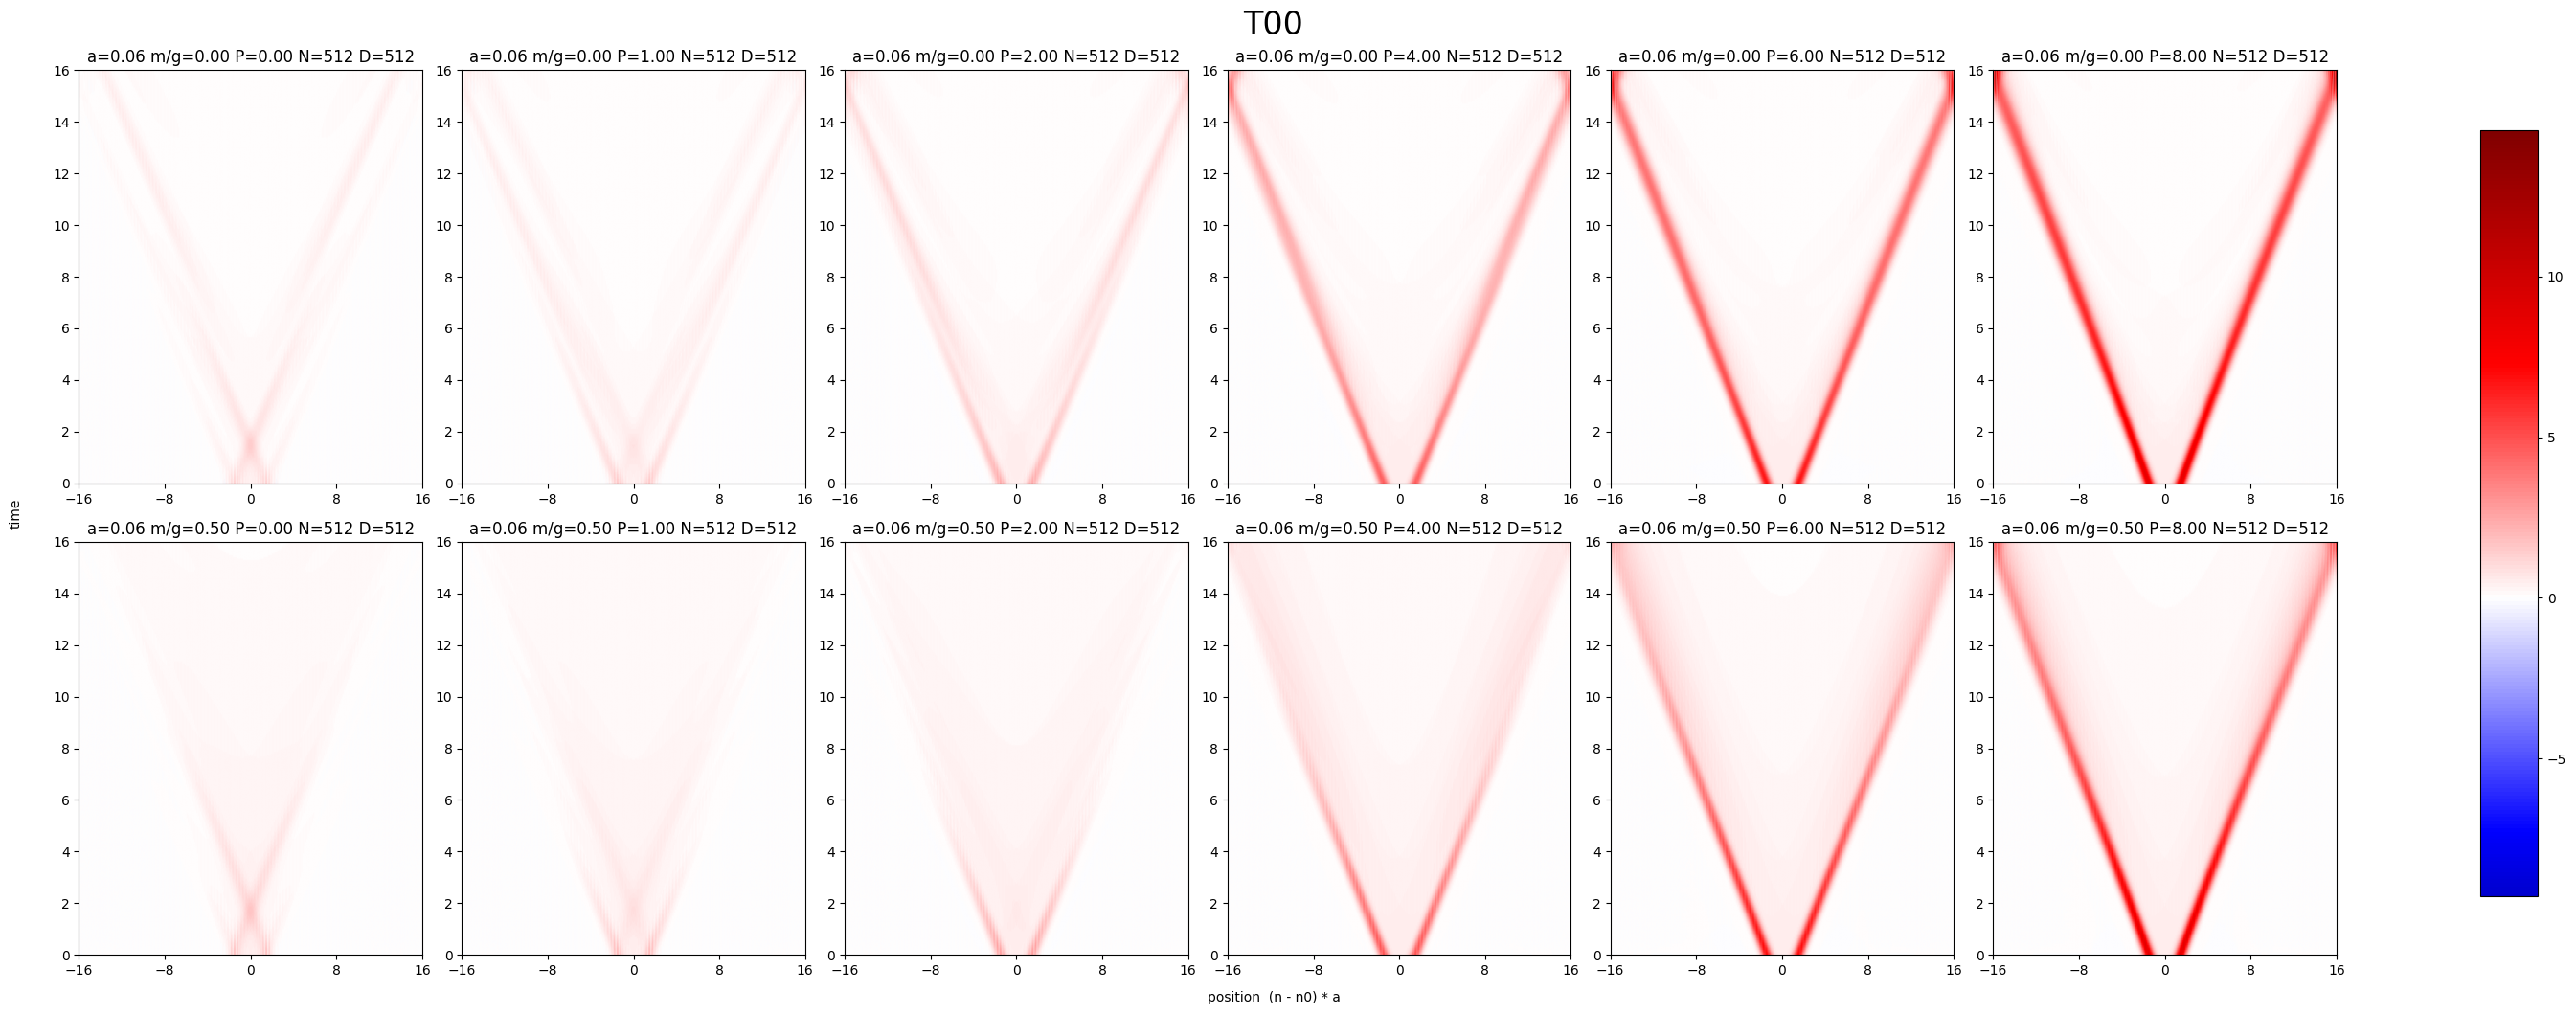

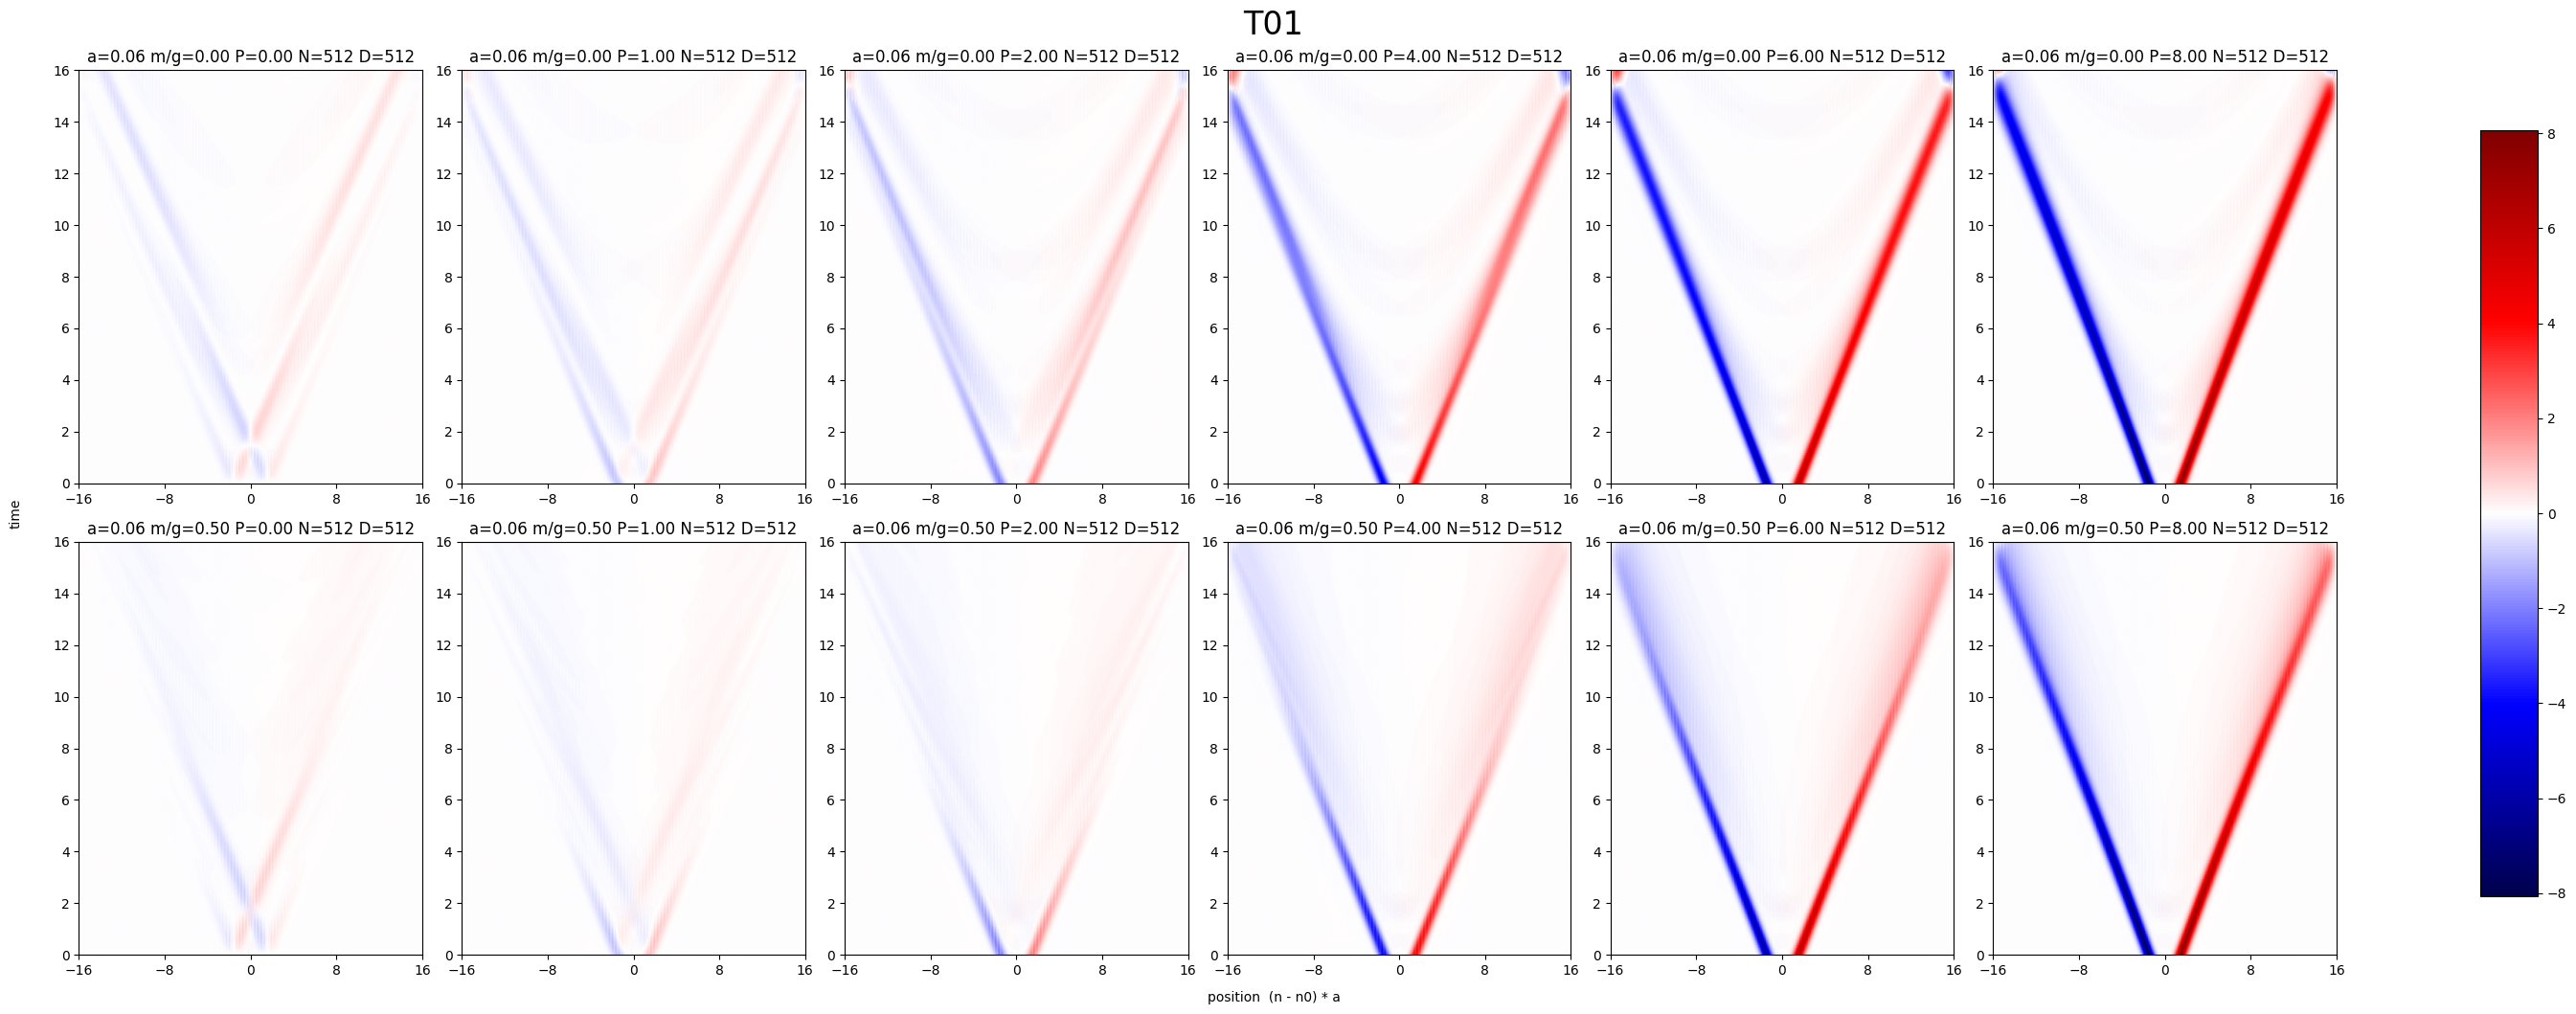

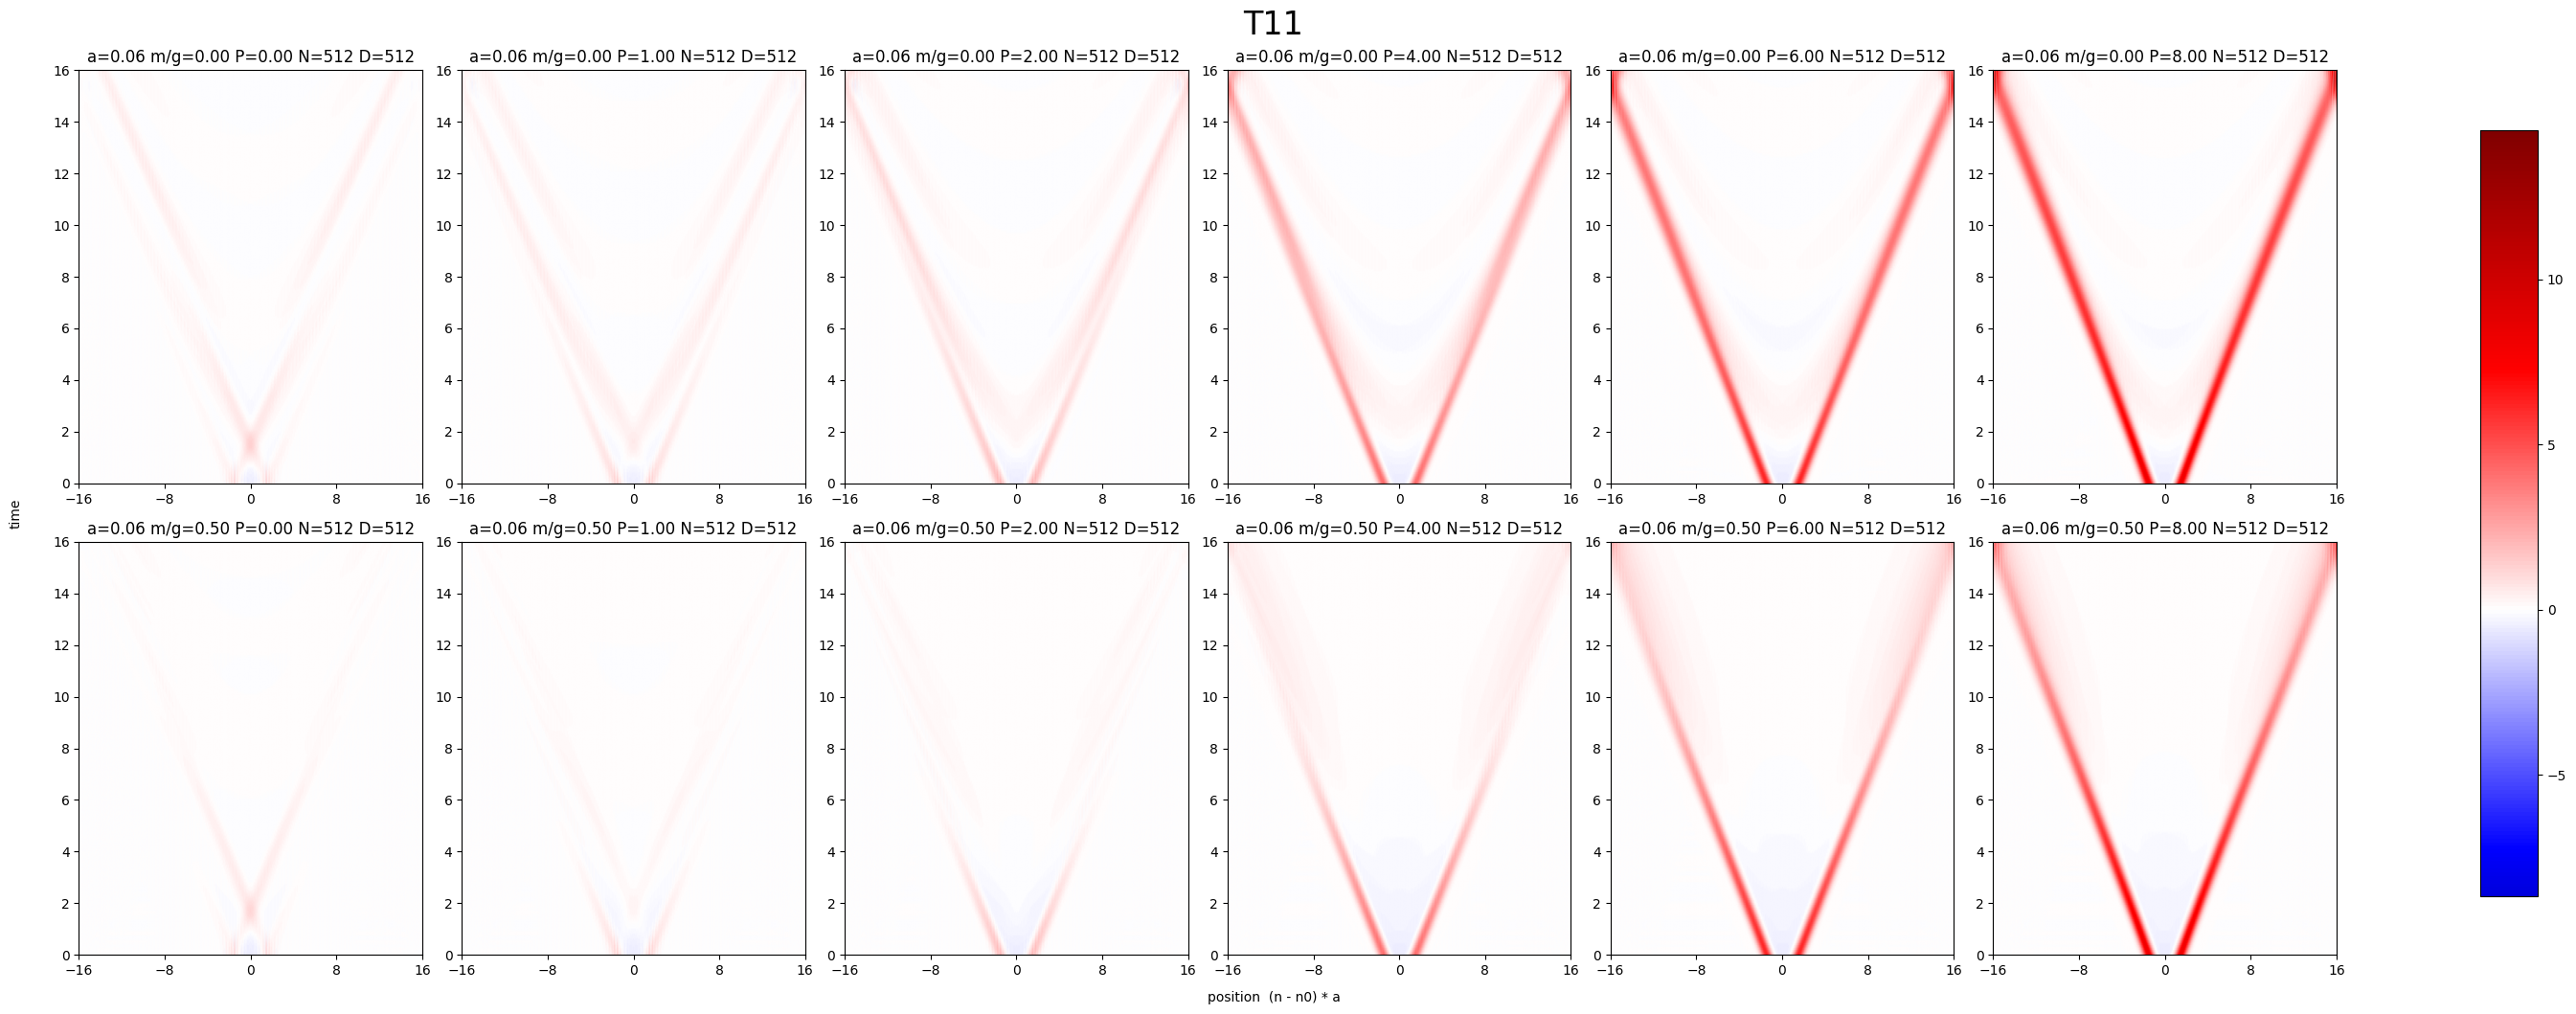

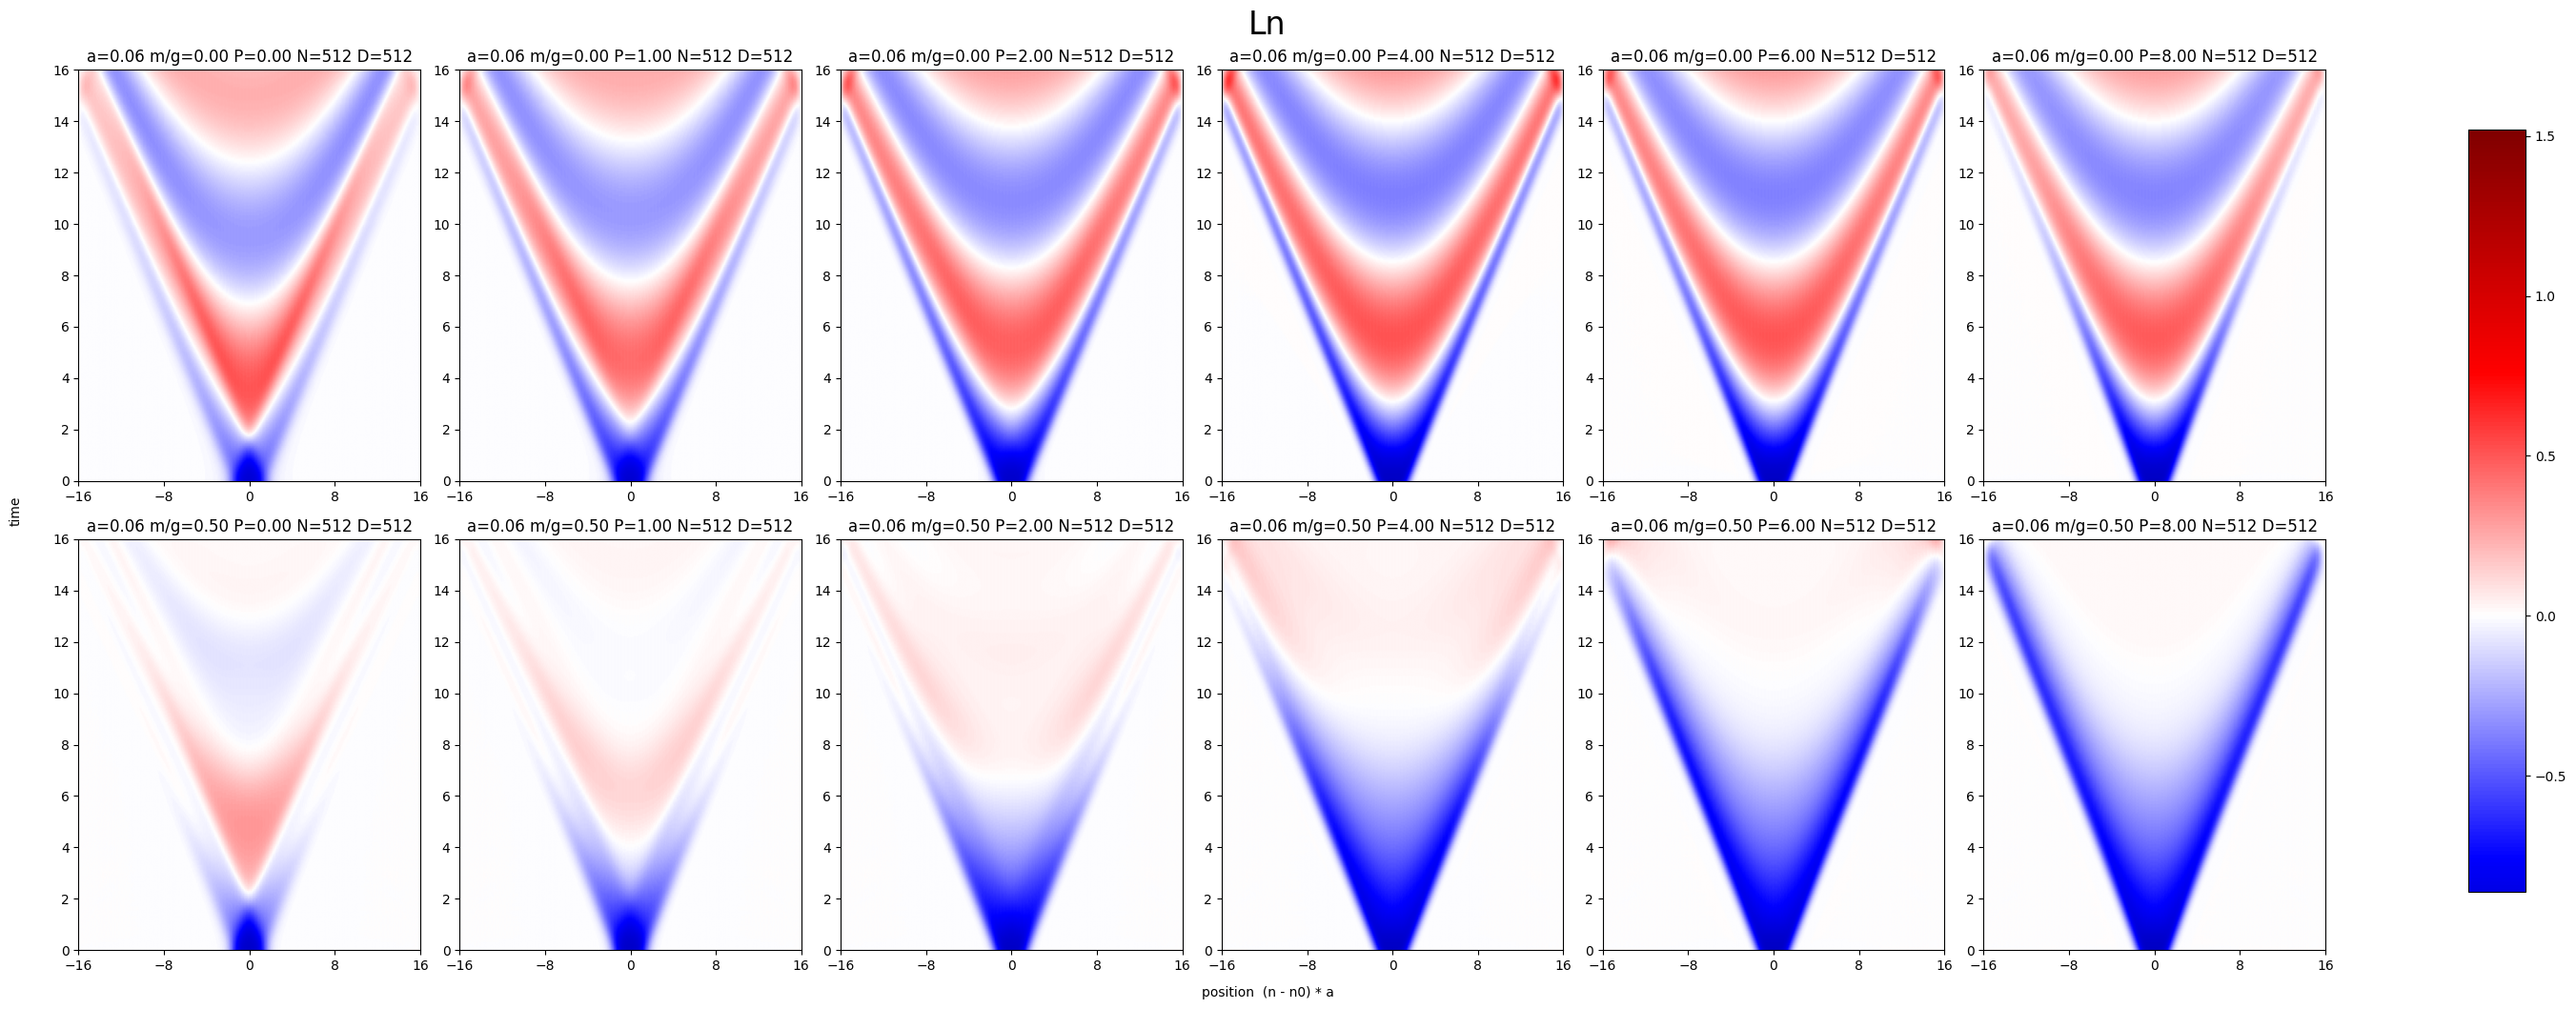

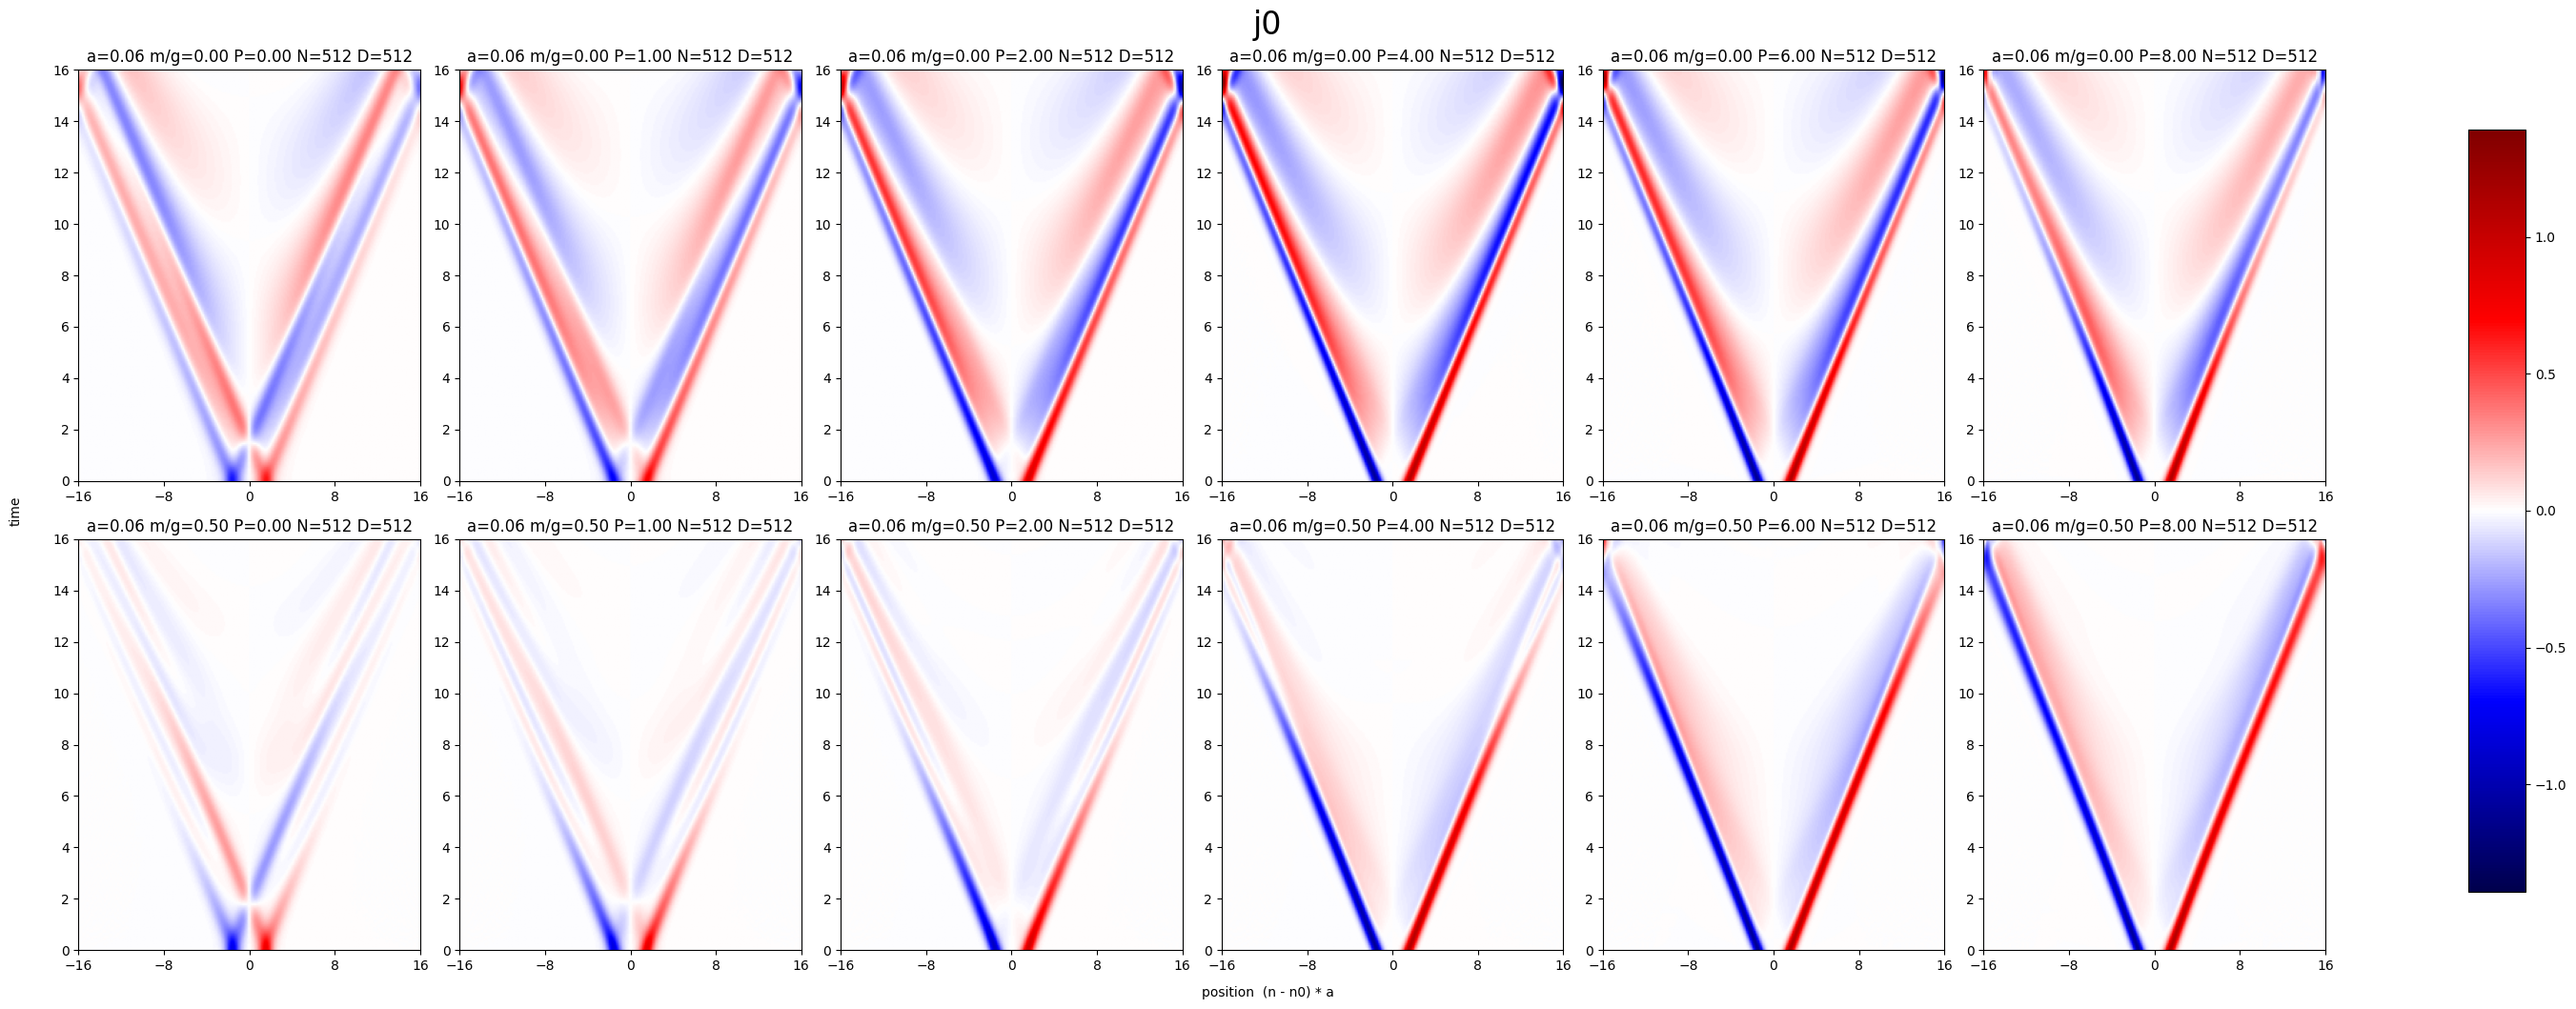

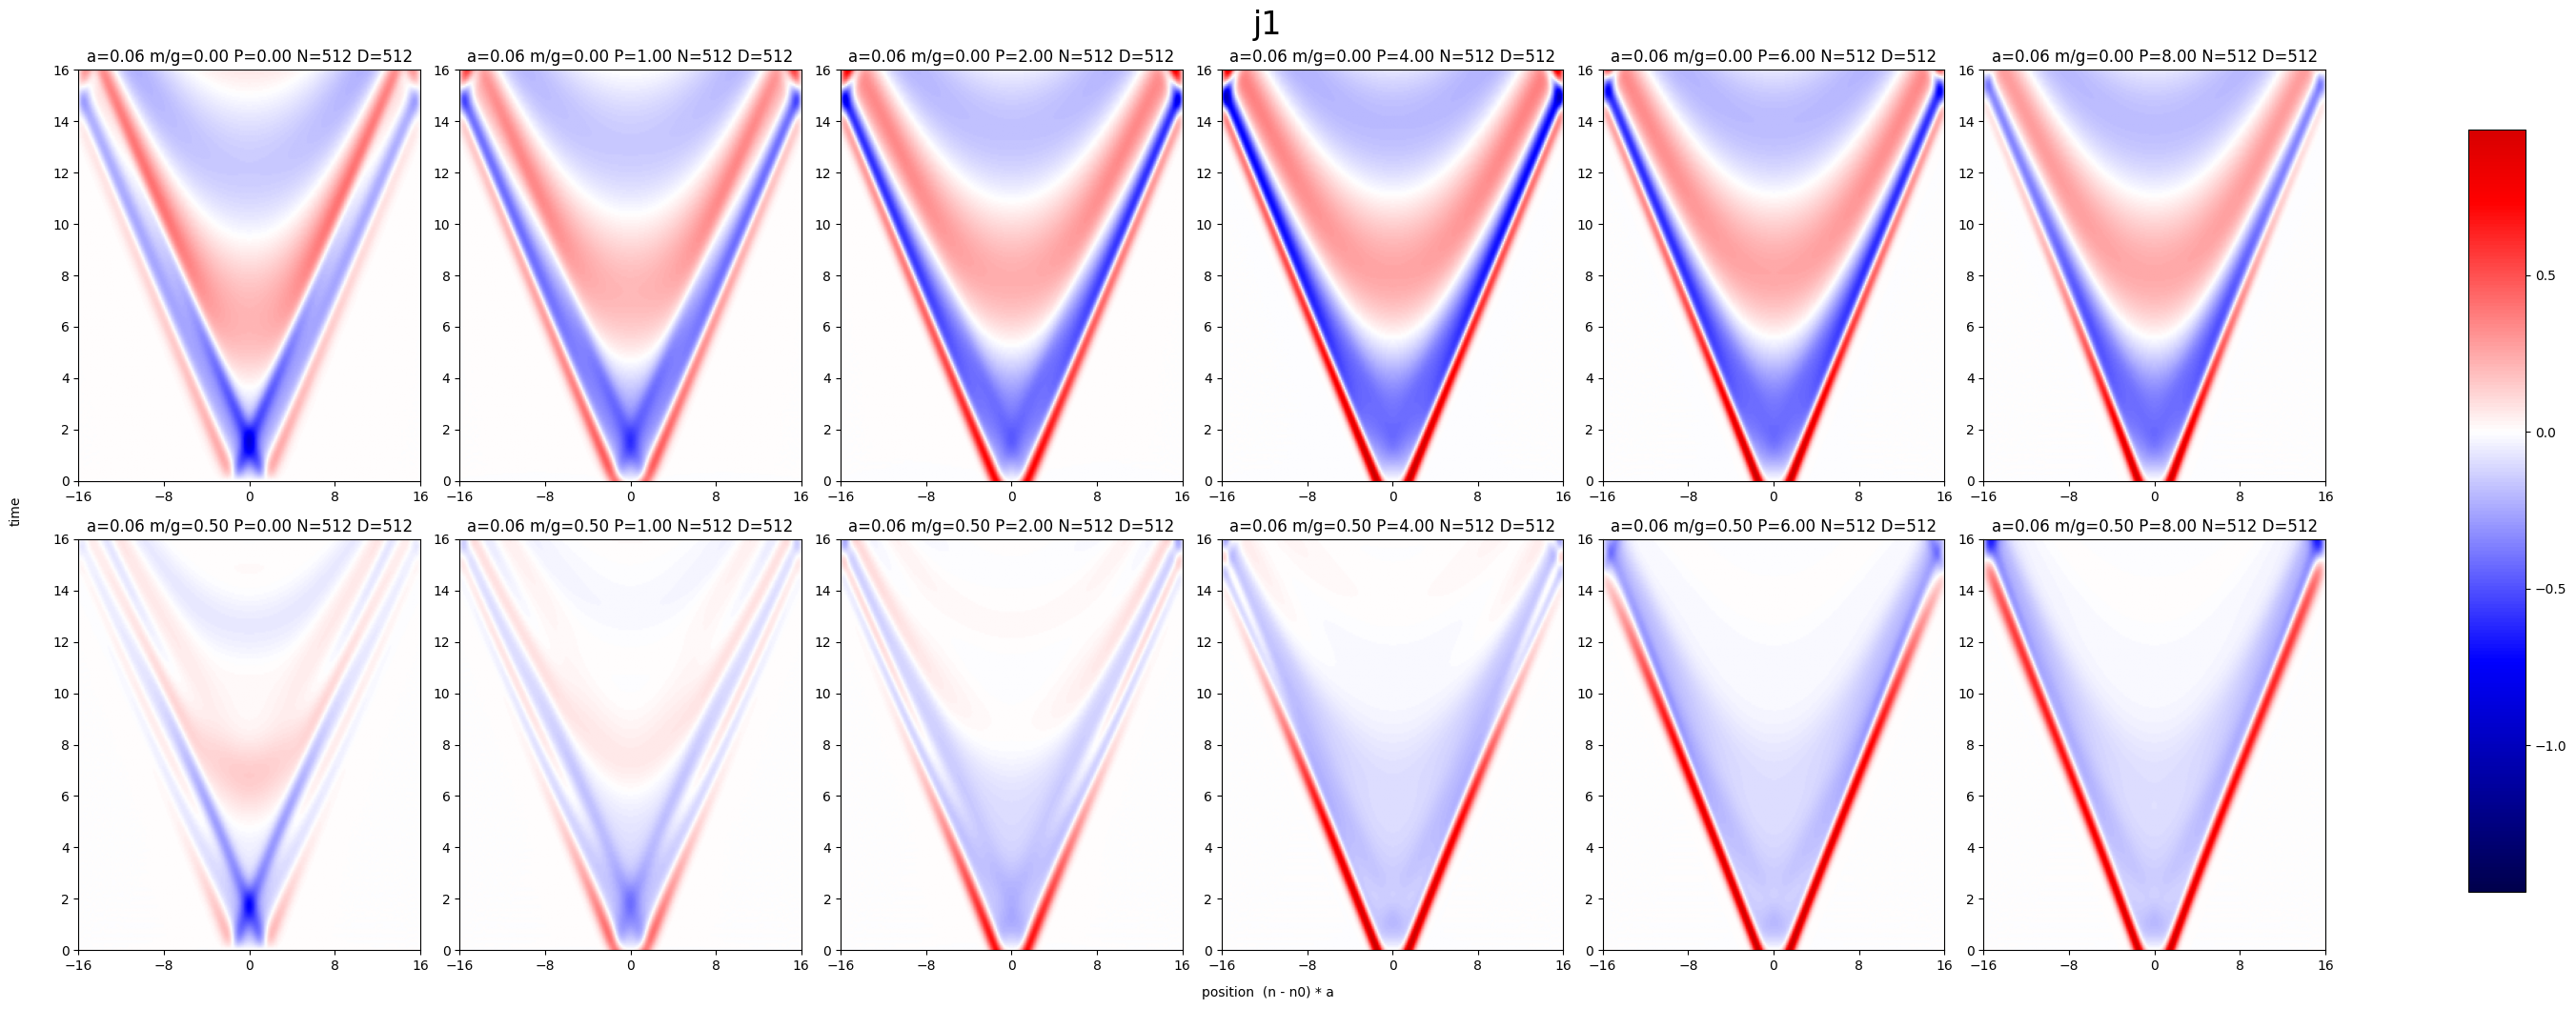

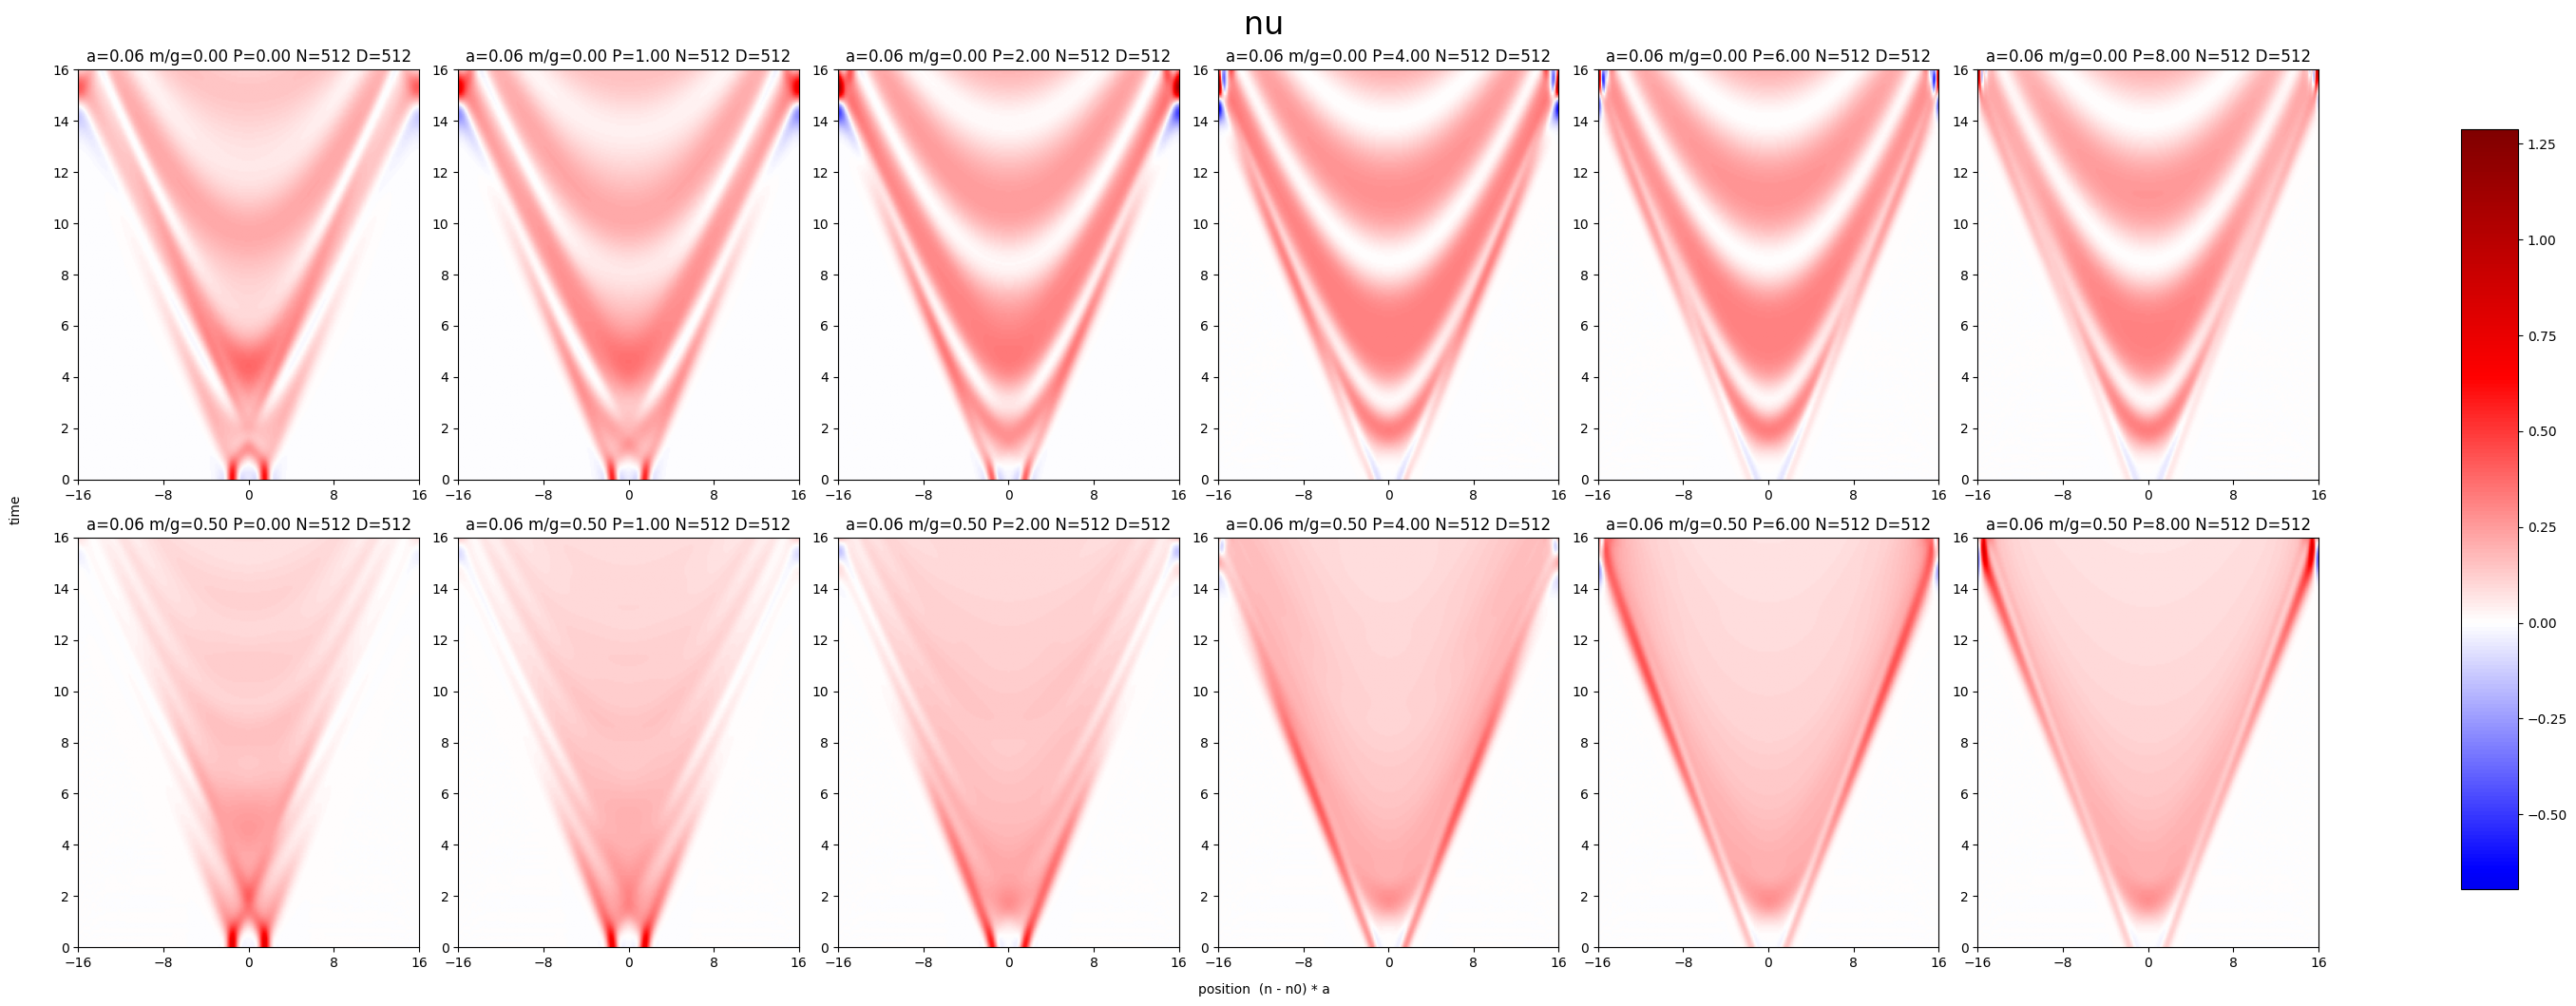

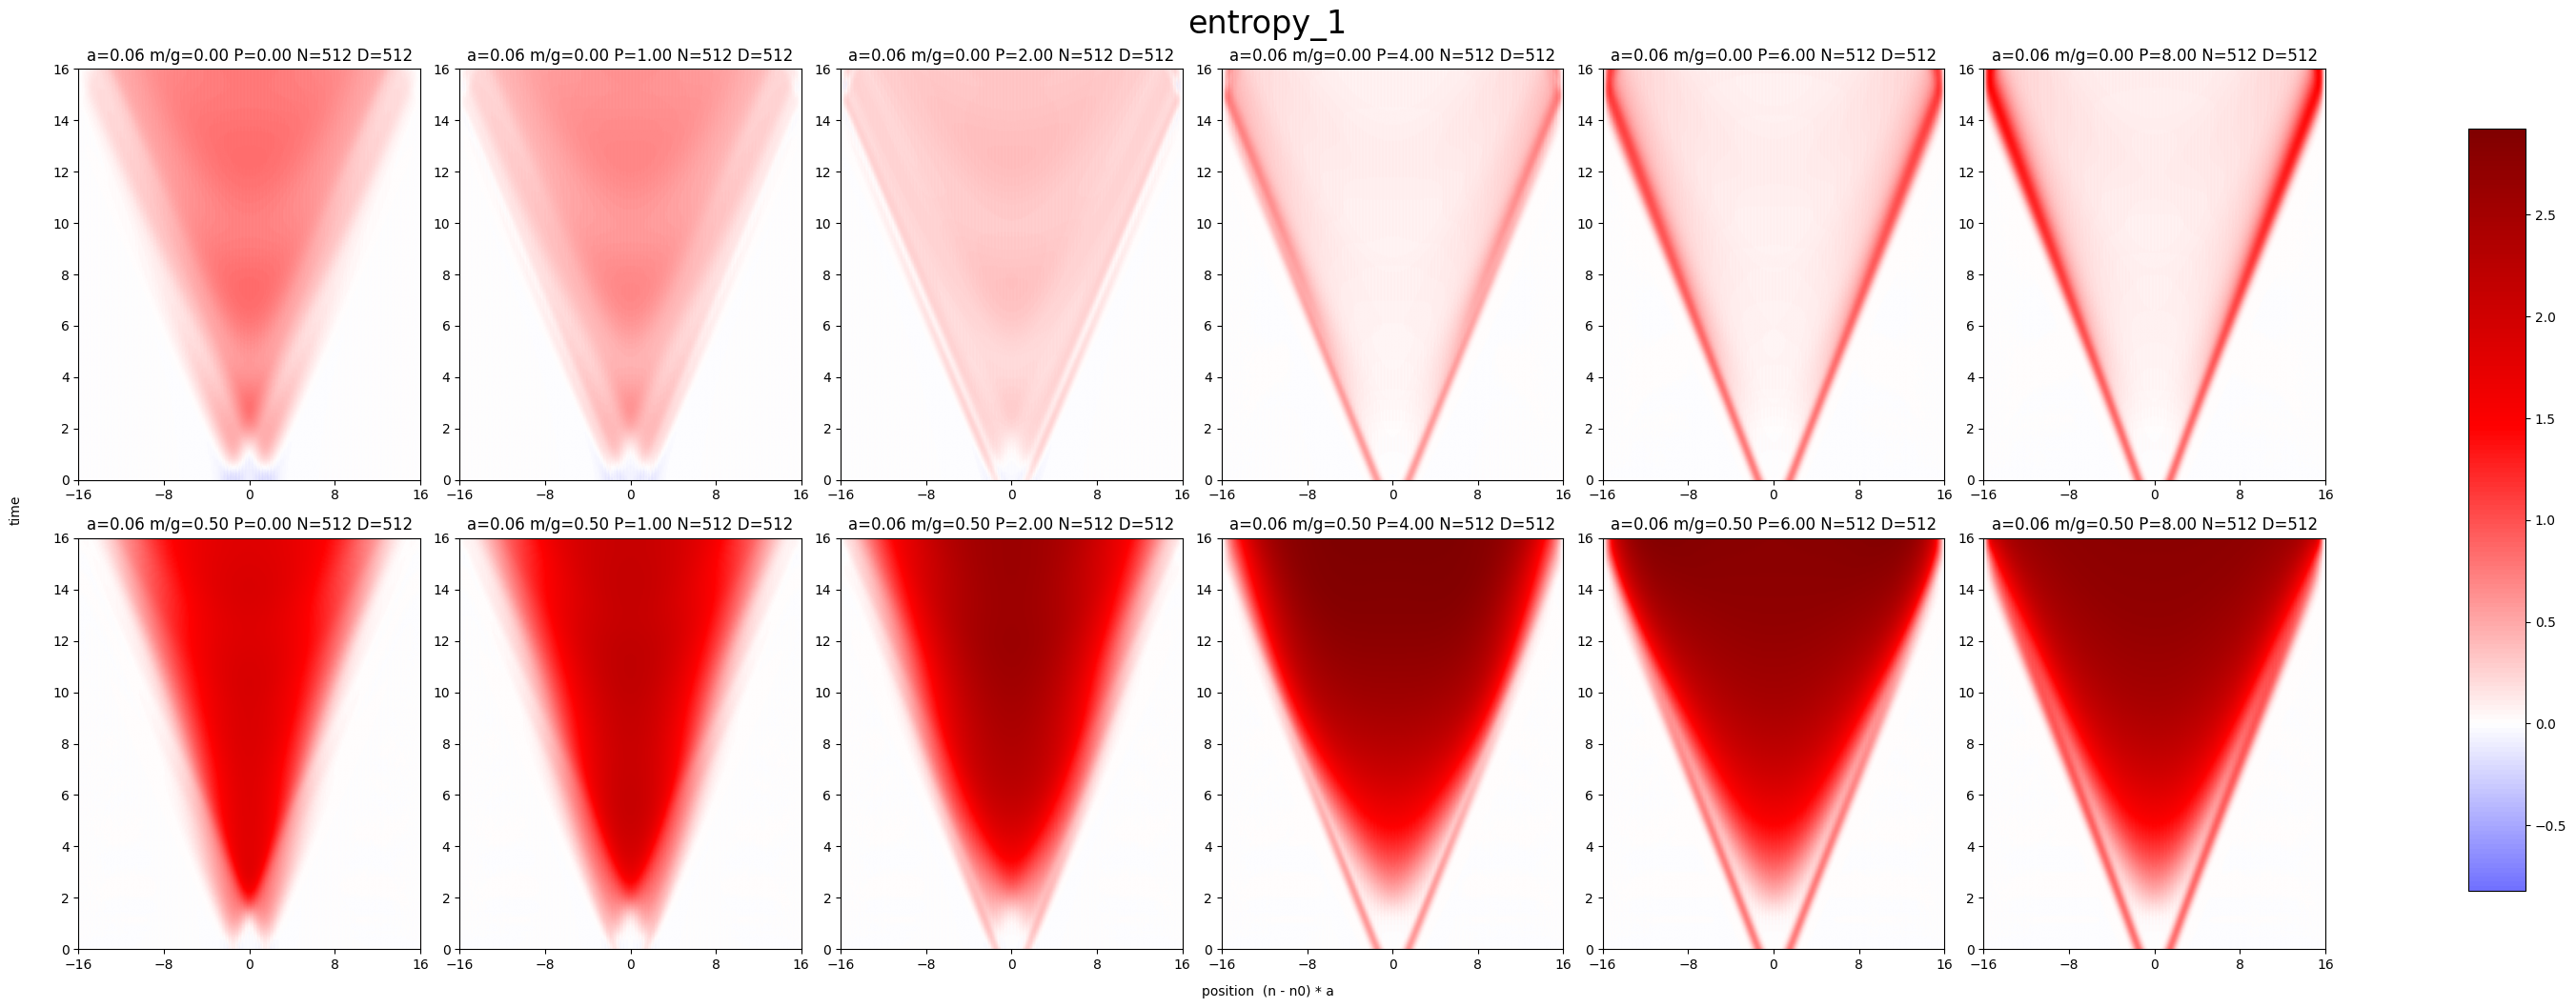

In [6]:
for ev in ['T00', 'T01', 'T11', 'Ln', 'j0', 'j1', 'nu', 'entropy_1']:
    plot_heatmaps(ev, data, g, ms, Ps, NaDdt, avarage_nn=False, tmax=None)

In [7]:
NUM_COLORS = 6
cm = plt.get_cmap('nipy_spectral') #hsv') #'gist_rainbow')
colors = [cm(i / (NUM_COLORS-0.5)) for i in range(NUM_COLORS)]
lines = ['-', '--', ':']

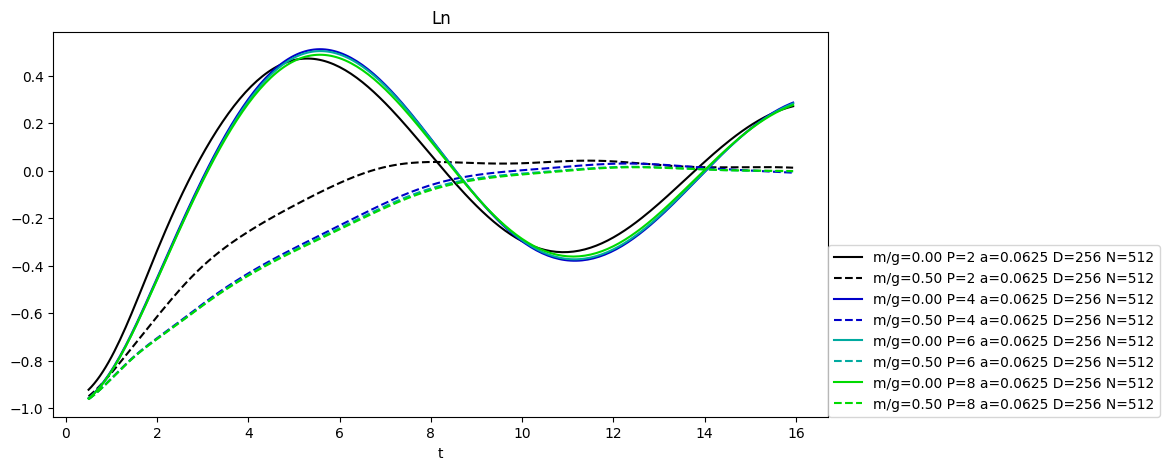

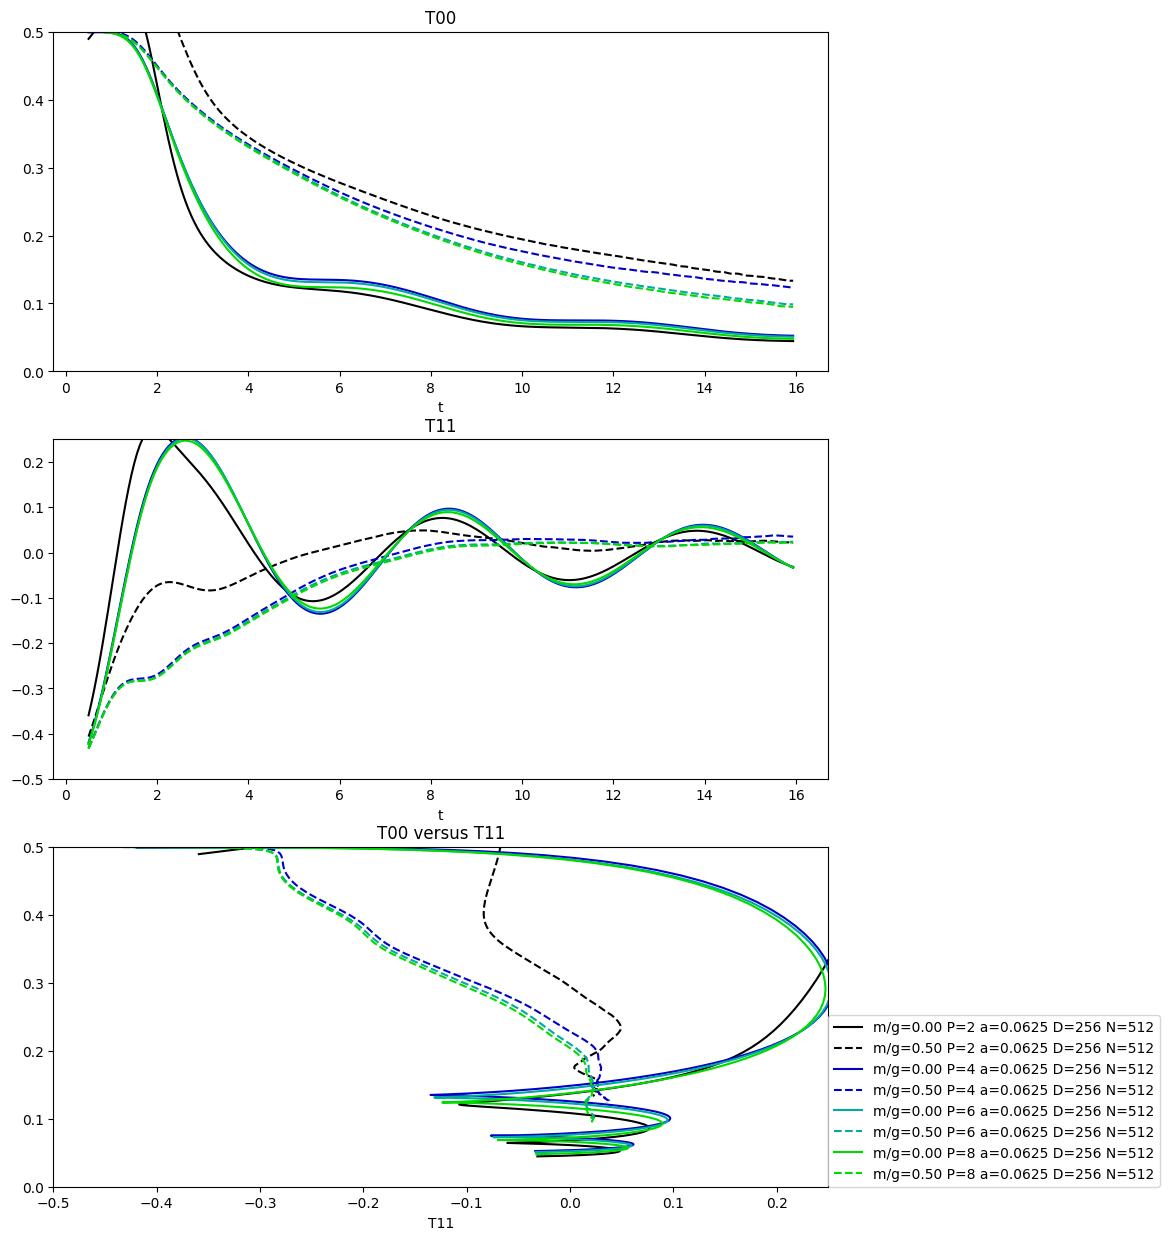

In [8]:
Nadt = [(N, a, 1/16)]
plt.figure(figsize=(10, 5))
D = 256

for (N, a, dt) in Nadt:
 for j, P in enumerate(Ps[2:]):
    for i, m in enumerate(ms):
        try:
            tm, ee, mid = get_tsm(data[m, P, N, a, D, dt], gs[m, a, N], 'Ln')
            line, = plt.plot(tm[8:-1], mid[8:-1], lines[i], color=colors[j])
            line.set_label(f'{m/g=:.2f} {P=} {a=} {D=} {N=}')
            # np.savetxt(f'Ln_{m=:.2f}.txt', np.column_stack([tm[8:-1], mid[8:-1]]))
        except KeyError:
            pass

plt.legend(loc=(1,0))
plt.xlabel('t')
plt.title('Ln')

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for (N, a, dt) in Nadt:
 for j, P in enumerate(Ps[2:]):
    for i, m in enumerate(ms):
        try:
            tm, ee, midE = get_tsm(data[m, P, N, a, D, dt], gs[m, a, N], 'T00')
            tm, ee, midp = get_tsm(data[m, P, N, a, D, dt], gs[m, a, N], 'T11')
            ax[0].plot(tm[8:-1], midE[8:-1], lines[i], color=colors[j], label=f'{m/g=:.2f} {P=} {a=} {D=} {N=}')
            ax[1].plot(tm[8:-1], midp[8:-1], lines[i], color=colors[j], label=f'{m/g=:.2f} {P=} {a=} {D=} {N=}')
            ax[2].plot(midp[8:-1], midE[8:-1], lines[i], color=colors[j], label=f'{m/g=:.2f} {P=} {a=} {D=} {N=}')
            if save:
                np.savetxt(f'T00_vs_t_{m=:.2f}.txt', np.column_stack([tm[8:-1], midE[8:-1]]))
                np.savetxt(f'T11_vs_t_{m=:.2f}.txt', np.column_stack([tm[8:-1], midp[8:-1]]))
                np.savetxt(f'T00_vs_T11_{m=:.2f}.txt', np.column_stack([midp[8:-1], midE[8:-1]]))
        except KeyError:
            pass

ax[0].set_title('T00')
ax[1].set_title('T11')
ax[2].set_title('T00 versus T11')

ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[2].set_xlabel('T11')

ax[0].set_ylim([0, 0.5])
ax[1].set_ylim([-0.5, 0.25])
ax[2].set_xlim([-0.5, 0.25])
ax[2].set_ylim([0, 0.5])

ax[2].legend(loc=(1, 0))
